# KMeans

KMeans is a basic but powerful clustering method which is optimized via Expectation Maximization. It randomnly selects K data points in X, and computes which samples are close to these points. For every cluster of points, a mean is computed (hence the name), and this becomes the new centroid.

cuML’s KMeans supports the fast KMeans++ intialization method. This method is more stable than randomnly selecting K points.

<br>

|  Parameters: |  Description:    |
| ------------ | ---------------- |
| `n_clusters:int (default = 8)` | The number of centroids or clusters you want. |
| `max_iter:int (default = 300)` | The more iterations of EM, the more accurate, but slower. |
| `tol:float (default = 1e-4)` | Stopping criterion when centroid means do not change much. |
| `verbose:boolean (default = 0)` | If True, prints diagnositc information. |
| `random_state:int (default = 1)` | If you want results to be the same when you restart Python, select a state. |
| `precompute_distances:boolean (default = ‘auto’)` | Not supported yet. |
| `init: (default = 'scalable-k-means++')` | 'scalable-k-means++' or 'k-means\|\|': Uses fast and stable scalable kmeans++ intialization. <br> 'random' or an ndarray: Choose 'n_cluster' observations (rows) at random from data for the initial centroids. <br> If an ndarray is passed, it should be of shape (n_clusters, n_features) and gives the initial centers. |
| `n_init:int (default = 1)` | Number of times intialization is run. More is slower, but can be better. |
| `algorithm:“auto”` | Currently uses full EM, but will support others later. |
| `n_gpu:int (default = 1)` | Number of GPUs to use. If -1 is used, uses all GPUs. More usage is faster. |

<br>

|  Methods:         |  Description:      |
| ------------------| -----------------  |
|`fit(self, X)` | Compute k-means clustering with X. |
|`fit_predict(self, X)` | Compute cluster centers and predict cluster index for each sample. |
|`fit_transform(self, input_gdf)` | Compute clustering and transform input_gdf to cluster-distance space. |
|`get_params(self[, deep])` | Sklearn style return parameter state |
|`predict(self, X)` | Predict the closest cluster each sample in X belongs to. |
|`set_params(self, **params)` | Sklearn style set parameter state to dictionary of params. |
|`transform(self, X)` | Transform X to a cluster-distance space. |

<br>
    
The model accepts only numpy arrays or cudf dataframes as the input. In order to convert your dataset to cudf format please read the cudf documentation on https://rapidsai.github.io/projects/cudf/en/latest/. For additional information on the DBSCAN model please refer to the documentation on https://rapidsai.github.io/projects/cuml/en/latest/index.html
    

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans as skKMeans
from sklearn import datasets
from cuml import KMeans as cumlKMeans
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

# Helper Functions

In [2]:
# calculate the time required by a cell to run
from timeit import default_timer

class Timer(object):
    def __init__(self):
        self._timer = default_timer
    
    def __enter__(self):
        self.start()
        return self

    def __exit__(self, *args):
        self.stop()

    def start(self):
        """Start the timer."""
        self.start = self._timer()

    def stop(self):
        """Stop the timer. Calculate the interval in seconds."""
        self.end = self._timer()
        self.interval = self.end - self.start

# Run tests

In [11]:
rs = 7
# create a blobs dataset with 500 samples and 10 features each
data, labels = datasets.make_blobs(
   n_samples=100000, n_features=2, centers=5, random_state=rs)

kmeans_sk = skKMeans(n_clusters=5, n_jobs=-1, random_state=rs)
kmeans_cuml = cumlKMeans(n_clusters=5, n_gpu=1, random_state=rs)

In [4]:
%%time
print("Calling sklearn fit")
kmeans_sk.fit(data)

Calling sklearn fit
CPU times: user 138 ms, sys: 236 ms, total: 374 ms
Wall time: 940 ms


In [12]:
%%time
print("Calling cuml fit")
kmeans_cuml.fit(data)

Calling cuml fit
CPU times: user 22.1 ms, sys: 20.3 ms, total: 42.4 ms
Wall time: 40.7 ms


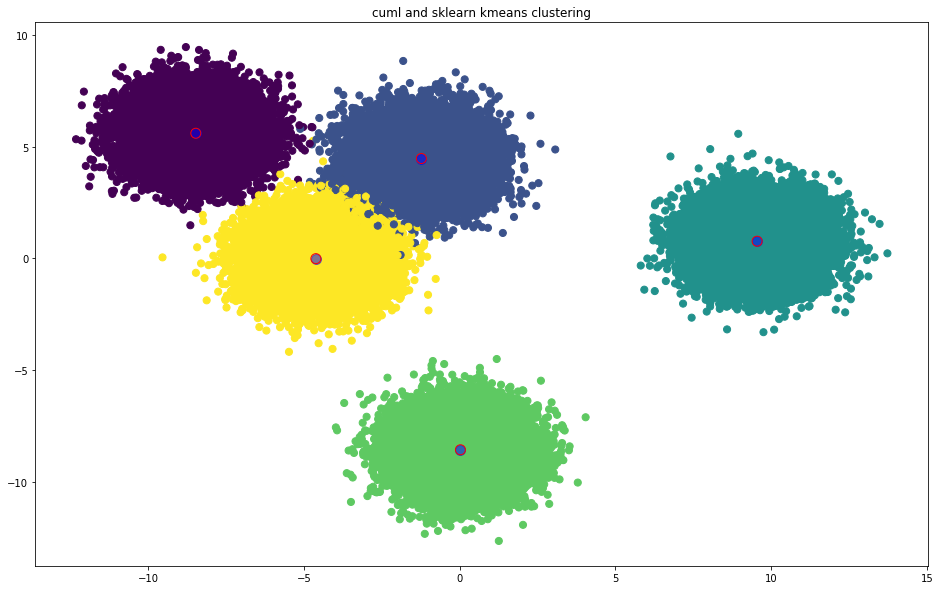

In [6]:
#plot the data
fig = plt.figure(figsize=(16, 10))
plt.scatter(data[:, 0], data[:, 1], c=labels, s=50, cmap='viridis')

#plot the sklearn kmeans centers with blue filled circles
centers_sk = kmeans_sk.cluster_centers_
plt.scatter(centers_sk[:,0], centers_sk[:,1], c='blue', s=100, alpha=.5)

#plot the cuml kmeans centers with red circle outlines
centers_cuml = kmeans_cuml.cluster_centers_
plt.scatter(centers_cuml['0'], centers_cuml['1'], facecolors = 'none', edgecolors='red', s=100)

plt.title('cuml and sklearn kmeans clustering')

plt.show()

In [7]:
%%time
#get cluster score of cuml and sklearn kmeans
cuml_score = adjusted_rand_score(labels, kmeans_cuml.labels_)
sk_score = adjusted_rand_score(labels, kmeans_sk.labels_)

CPU times: user 16.9 s, sys: 479 ms, total: 17.4 s
Wall time: 17.4 s


In [8]:
# check if the kmeans scores are equal up to a set threshold
threshold = 1e-5

passed = (cuml_score - sk_score) < threshold
message = 'compare kmeans: cuml vs sklearn labels_ are ' + ('equal' if passed else 'NOT equal')
print(message)

compare kmeans: cuml vs sklearn labels_ are equal
